In [486]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [487]:
num = '001'
behavior = 'human drivers'
volume = '2400'
veh_raw_data_file_newname = f'{behavior}_{num}.csv'

In [488]:
for filename in os.listdir('.'):
    if filename == f'{behavior}_{num}.fzp':
        os.rename(filename,veh_raw_data_file_newname)

In [489]:
veh_df = pd.read_csv(veh_raw_data_file_newname,sep=';',index_col=False,skiprows=range(19))

In [490]:
veh_df.columns = ['time','veh_no','link_no','lane_no','position','distance','lateral_position']
veh_df = veh_df[['time','veh_no','link_no','lane_no','distance']]
veh_df.sort_values(['veh_no','time']).head()

,time,veh_no,link_no,lane_no,distance
1,2.0,1,103,1,42.44
3,3.0,1,103,1,63.66
7,4.0,1,103,1,84.87
11,5.0,1,103,1,106.09
17,6.0,1,103,1,127.31


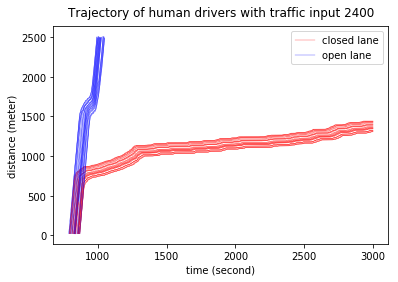

In [491]:
lw = 0.3
for vehicle in range(500,550): 
    vehicle_df = veh_df[veh_df['veh_no']==vehicle]
    right_lane_df = vehicle_df[np.all([vehicle_df['link_no']!=123,vehicle_df['lane_no']==1],axis=0)]
    left_lane_index = set(vehicle_df.index)-set(right_lane_df.index)
    left_lane_df = vehicle_df.loc[left_lane_index].sort_values('time')
    x_left_lane = left_lane_df['time']
    y_left_lane = left_lane_df['distance']
    x_right_lane = right_lane_df['time']
    y_right_lane = right_lane_df['distance']
    plt.plot(x_left_lane,y_left_lane,'b',linestyle='solid',linewidth=lw,label='open lane')
    plt.plot(x_right_lane,y_right_lane,'r',linestyle='solid',linewidth=lw,label='closed lane')
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')
plt.xlabel('time (second)')
plt.ylabel('distance (meter)')
plt.title(f'Trajectory of {behavior} with traffic input {volume}',pad=10)
plt.savefig(f'Trajectory of {behavior} with traffic input {volume}.png')

In [492]:
veh_df = veh_df[veh_df['link_no']!=123]
veh_df['distance_interval'] = veh_df['distance']//100
veh_df = veh_df[veh_df['distance_interval']<=25]

In [493]:
veh_df['time_minute'] = veh_df['time']//60
start_min = 15
end_min = 45
veh_df = veh_df[np.all([veh_df['time_minute']>=15,veh_df['time_minute']<=45],axis=0)]

In [494]:
veh_df['distance'].max()

2197.7

In [495]:
grouped = veh_df.groupby(['time_minute','distance_interval'])
df_heatmap = grouped['veh_no'].agg('count')

df_heatmap = pd.DataFrame(df_heatmap)
df_heatmap.columns = [['density']]
df_heatmap = df_heatmap.reset_index(level=['time_minute', 'distance_interval'])
df_heatmap.columns = df_heatmap.columns.get_level_values(0)
df_heatmap = df_heatmap.astype('int64', copy=False)
df_heatmap_pivot = df_heatmap.pivot_table(index='time_minute', columns='distance_interval', values='density')
df_heatmap_pivot = df_heatmap_pivot.sort_values('time_minute',ascending=False)


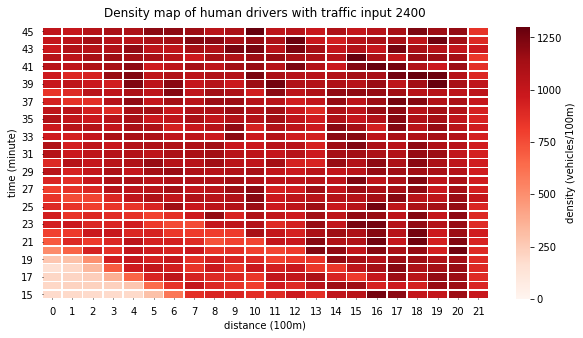

In [496]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
sns.heatmap(df_heatmap_pivot,cmap="Reds",linewidths=0.5,vmin=0, vmax=1300,
            cbar_kws={'label': 'density (vehicles/100m)'})
plt.tick_params(direction='in',length=1,pad=8,labelrotation=0)
#plt.xticks(range(0,22,2),range(0,22,2))
ax.set_xlabel('distance (100m)',fontsize=10)
ax.set_ylabel('time (minute)',fontsize=10)
ax.set_title(f'Density map of {behavior} with traffic input {volume}',pad=10)
plt.savefig(f'Density map of {behavior} with traffic input {volume}.png')